# **PCA e Regressione**

### In questo notebook si effettua la Principal Component Analysis sugli array generati nella fase di preprocessing, e si va poi ad addestrare dei modelli di regressione che siano in grado di predire gli angoli di Eulero data la codifica frattale di una foto.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
from os import path
import math
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn import linear_model

## Preparazione dei dati per la PCA

La prima fase consiste nell'uniformare e normalizzare i dati a disposizione.<br>
Si leggono dal file `csv` gli array memorizzati, e si uniforma la loro dimensione a quella dell'array di dimensione massima. <br>
Gli spazi vuoti sono riempiti con il valore di outlier 1000, in modo da non essere selezionato dalla PCA come componente principale.


In [ ]:
project_path = path.join(os.getcwd(), "drive", "My Drive", "Progetto")
df = pd.read_csv(path.join(project_path, 'arrays_min_nan.csv'))

NCOL = 6144
MIN = -1
MAX = 1

In [ ]:
# Funzioni di utilità

def array_from_string(s):
    s = s[1:len(s) - 1]
    return [float(x) for x in s.split(',')]


def scale_column_between_range(df, col, min, max):    
    column = df[col]
    col_min = column.min()
    col_max = column.max()
    return ((column - col_min) / (col_max - col_min)) * (max - min) + min

In [ ]:
arrays = []
df.reset_index()

# Rimozione delle colonne non utili
print("Remove columns...")
for index, row in tqdm(df.iterrows(), desc="Creating DataFrame..."):
    arrays.append(array_from_string(row['array']))

df = pd.DataFrame(arrays)

print("Filling NaN values...")
# Riempimento con il valore di outlier
OUTLIER = 1000
df.fillna(OUTLIER, inplace=True)

Remove columns...


Creating DataFrame...: 11302it [00:31, 364.03it/s]


Filling NaN values...


In [ ]:
# Normalizzazione dei dati fra -1 ed 1

x = StandardScaler().fit_transform(df)

display(x)

array([[-0.20229365, -0.87434351,  0.99224385, ...,  0.02639769,
         0.02661465,  0.02651073],
       [ 1.24999852,  1.73065119,  0.99224385, ...,  0.02639769,
         0.02661465,  0.02651073],
       [-0.20229365, -0.44017772, -1.00781678, ...,  0.02639769,
         0.02661465,  0.02651073],
       ...,
       [ 0.00517666, -1.30850929, -1.00781678, ...,  0.02639769,
         0.02661465,  0.02651073],
       [-1.03217489,  0.86231963,  0.99224385, ...,  0.02639769,
         0.02661465,  0.02651073],
       [ 1.66493914,  0.64523673, -1.00781678, ...,  0.02639769,
         0.02661465,  0.02651073]])

## Analisi sulla PCA

Partendo da una percentuale di varianza del 95% e scalando del -5% ad ogni prova, si è effettuata la PCA per ottenere il numero di componenti principali. <br>

In [ ]:
pca = PCA(.95)
pca.fit(x)
print(pca.n_components_)

2861


In [ ]:
pca = PCA(.90)
pca.fit(x)
print(pca.n_components_)

2327


In [ ]:
pca = PCA(.85)
pca.fit(x)
print(pca.n_components_)

1931


In [ ]:
pca = PCA(.80)
pca.fit(x)
print(pca.n_components_)

1609


In [ ]:
pca = PCA(.75)
pca.fit(x)
print(pca.n_components_)

1337


In [ ]:
pca = PCA(.70)
pca.fit(x)
print(pca.n_components_)

Sono state selezionate le percentuali di varianza che hanno fornito un numero di componenti maggiore di **2000**. <br>
Poiché non si è verificata una riduzione significativa delle componenti tra una percentuale ed un'altra, per la fase successiva sono state selezionate tre percentuali:
- 85%
- 90%
- 95%


## Preparazione dei dati alla regressione

Dopo aver individuato la percentuale di varianza utile a generare le componenti principali dei dati, si passa alla preparazione di quest'ultimi per effettuare la regressione. <br>
Il primo passo è quello di estrarre dal dataset le **true label** per il training.


In [ ]:
tmp_df = pd.read_csv(path.join(project_path, 'arrays_min_nan.csv'))

pitch = []
yaw = []
roll = []

for index, row in tqdm(tmp_df.iterrows(), desc="Creating DataFrame..."):
    pitch.append((row['pitch']))
    yaw.append((row['yaw']))
    roll.append((row['roll']))  

Creating DataFrame...: 11302it [00:02, 4066.24it/s]

[7.61, 7.65, 7.45, 7.46, 7.73, 7.53, 7.55, 7.68, 7.48, 7.59, 7.5, 7.61, 7.84, 7.93, 8.11, 8.37, 8.97, 9.63, 10.56, 12.3, 15.25, 18.95, 22.05, 24.85, 26.84, 28.84, 29.92, 30.54, 30.7, 30.8, 31.78, 32.87, 35.24, 36.32, 36.19, 37.62, 37.95, 37.52, 38.94, 40.02, 40.13, 39.76, 40.42, 39.54, 40.25, 39.61, 39.69, 38.97, 39.01, 38.54, 38.07, 36.59, 32.86, 32.96, 32.73, 32.98, 32.95, 33.36, 33.21, 32.99, 32.53, 33.0, 32.39, 32.31, 32.38, 32.05, 32.21, 31.89, 31.6, 31.52, 31.71, 30.9, 30.55, 30.76, 30.55, 30.23, 30.22, 30.05, 30.26, 30.12, 29.88, 30.13, 29.71, 29.9, 29.86, 29.78, 29.46, 29.08, 29.46, 29.34, 29.81, 29.54, 29.2, 29.11, 28.65, 28.23, 28.8, 28.62, 28.45, 28.39, 28.23, 28.12, 28.13, 28.26, 28.0, 28.1, 28.25, 27.76, 27.76, 27.67, 27.49, 27.39, 27.51, 26.96, 26.92, 26.81, 27.42, 26.73, 26.49, 26.2, 24.87, 24.51, 23.83, 22.94, 21.49, 21.2, 20.37, 19.85, 18.46, 17.68, 17.46, 16.55, 15.82, 15.29, 14.51, 14.02, 13.6, 12.51, 11.66, 11.59, 11.21, 10.99, 10.6, 10.27, 10.59, 10.53, 10.38, 10.0

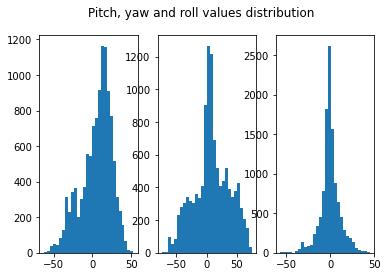

In [ ]:
# Analisi della distribuzione dei dati

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.suptitle("Pitch, yaw and roll values distribution")
ax1.hist(pitch, bins = 30)
ax2.hist(yaw, bins = 30)
ax3.hist(roll, bins = 30)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
import sklearn.metrics as metrics

Si procede poi, per ciascuno degli angoli, ad effettuare la separazione in `test_set` pari ad 1/8 dei dati originali, e `train_set`.

In [ ]:
# test_size: what proportion of original data is used for test set
train_data_pitch, test_data_pitch, train_lbl_pitch, test_lbl_pitch= train_test_split(x, pitch, test_size=1/8.0, random_state=0)

## Modelli di regressione

Per ciascuno degli angoli di Eulero viene poi rieseguita la PCA su ciascuna delle percentuali di varianza scelte, vengono addestrati i seguenti modelli di regressione:
- Linear Regression
- Bayesian Ridge
- Lasso
- Gradient Boosting Regressor
- XGBoost Regressor

In seguito, vengono calcolati lo `score` e il `mean_absolute_error`

In [ ]:
#PCA con varianza pari a .85% -PITCH
pca = PCA(.85)
pca.fit(train_data_pitch)
num_components_pca_85 = pca.n_components_
print(pca.n_components_)
train_data_pitch_85 = pca.transform(train_data_pitch)
test_data_pitch_85 = pca.transform(test_data_pitch)

1868


In [ ]:
#Regressione con Modello Lineare
model = LinearRegression()
model.fit(train_data_pitch_85, train_lbl_pitch)
predict_pitch_linear_85= model.predict(test_data_pitch_85)
score_linear_pitch_85=model.score(test_data_pitch_85, test_lbl_pitch)
coef_linear_pitch_85=model.coef_
intercept_linear_pitch_85=model.intercept_
error_linear_pitch_85=metrics.mean_absolute_error(test_lbl_pitch,predict_pitch_linear_85)
print(f"Score: {score_linear_pitch_85 * 100}%")
print(f"Coef: {coef_linear_pitch_85}")
print(f"Intercept: {intercept_linear_pitch_85}")
print("Mean Absolute Error - PITCH: ", error_linear_pitch_85)

#Regressione con Modello Lineare Bayesian Ridge
bayesian = linear_model.BayesianRidge()
bayesian.fit(train_data_pitch_85, train_lbl_pitch)
score_bayesian_pitch_85 = bayesian.score(test_data_pitch_85, test_lbl_pitch)
predict_pitch_bayesian_85= bayesian.predict(test_data_pitch_85)
error_bayesian_pitch_85=metrics.mean_absolute_error(test_lbl_pitch,predict_pitch_bayesian_85)
print(f"Score: {score_bayesian_pitch_85 * 100}%")
print("Mean Absolute Error - PITCH: ", error_bayesian_pitch_85)

#Regressione con Modello Lineare Lasso
lasso = linear_model.Lasso()
lasso.fit(train_data_pitch_85, train_lbl_pitch)
predict_pitch_lasso_85 = lasso.predict(test_data_pitch_85)
score_lasso_pitch_85 = lasso.score(test_data_pitch_85, test_lbl_pitch)
error_lasso_pitch_85 = metrics.mean_absolute_error(test_lbl_pitch,predict_pitch_lasso_85)
print(f"Score: {score_lasso_pitch_85 * 100}%")
print("Mean Absolute Error - PITCH: ", error_lasso_pitch_85)

#Regressione con Modello GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(train_data_pitch_85, train_lbl_pitch)
predict_pitch_gbr_85= gbr.predict(test_data_pitch_85)
score_gbr_pitch_85=gbr.score(test_data_pitch_85, test_lbl_pitch)
error_gbr_pitch_85= metrics.mean_absolute_error(test_lbl_pitch,predict_pitch_gbr_85)
print(f"Score: {score_gbr_pitch_85 * 100}%")
print(f"Mean Absolute Error - PITCH: {error_gbr_pitch_85}")

#Regressione con Modello XGBRegressor
xgbr = xgb.XGBRegressor(verbosity=0)
xgbr.fit(train_data_pitch_85, train_lbl_pitch)
predict_pitch_xgbr_85= xgbr.predict(test_data_pitch_85)
score_xgbr_pitch_85= xgbr.score(test_data_pitch_85, test_lbl_pitch)
error_xgbr_pitch_85=metrics.mean_absolute_error(test_lbl_pitch,predict_pitch_xgbr_85)
print(f"Score: {score_xgbr_pitch_85* 100}%")
print("Mean Absolute Error - PITCH: ", error_xgbr_pitch_85)

Score: 22.77815489490187%
Coef: [ 0.0742527   0.17788286 -0.03164884 ...  0.18539446  0.24789072
 -0.04716797]
Intercept: 5.394283547375875
Mean Absolute Error - PITCH:  13.04491503005535
Score: 28.19016220786429%
Mean Absolute Error - PITCH:  12.641249517109667
Score: 25.477570576206997%
Mean Absolute Error - PITCH:  13.006146228981168
Score: 36.138301138853414%
Mean Absolute Error - PITCH: 12.076023828442478
Score: 36.583555921975496%
Mean Absolute Error - PITCH:  12.018711800274911


In [ ]:
#PCA con varianza pari a .90% -PITCH
pca = PCA(.90)
pca.fit(train_data_pitch)
print(pca.n_components_)
num_components_pca_90 = pca.n_components_
train_data_pitch_90 = pca.transform(train_data_pitch)
test_data_pitch_90 = pca.transform(test_data_pitch)

2260


In [ ]:
#Regressione con Modello Lineare
model = LinearRegression()
model.fit(train_data_pitch_90, train_lbl_pitch)
predict_pitch_linear_90= model.predict(test_data_pitch_90)
score_linear_pitch_90=model.score(test_data_pitch_90, test_lbl_pitch)
coef_linear_pitch_90=model.coef_
intercept_linear_pitch_90=model.intercept_
error_linear_pitch_90=metrics.mean_absolute_error(test_lbl_pitch,predict_pitch_linear_90)
print(f"Score: {score_linear_pitch_90 * 100}%")
print(f"Coef: {coef_linear_pitch_90}")
print(f"Intercept: {intercept_linear_pitch_90}")
print("Mean Absolute Error - PITCH: ", error_linear_pitch_90)

#Regressione con Modello Lineare Bayesian Ridge non può essere fatto perchè
# X ha 2798 features, ma la Regressione Lineare si aspetta 2260 features come input.
bayesian = linear_model.BayesianRidge()
bayesian.fit(train_data_pitch_90, train_lbl_pitch)
score_bayesian_pitch_90 = bayesian.score(test_data_pitch_90, test_lbl_pitch)
predict_pitch_bayesian_90= bayesian.predict(test_data_pitch_90)
error_bayesian_pitch_90=metrics.mean_absolute_error(test_lbl_pitch,predict_pitch_bayesian_90)
print(f"Score: {score_bayesian_pitch_90 * 100}%")
print("Mean Absolute Error - PITCH: ", error_bayesian_pitch_90)

#Regressione con Modello Lineare Lasso
lasso = linear_model.Lasso()
lasso.fit(train_data_pitch_90, train_lbl_pitch)
predict_pitch_lasso_90 = lasso.predict(test_data_pitch_90)
score_lasso_pitch_90 = lasso.score(test_data_pitch_90, test_lbl_pitch)
error_lasso_pitch_90 = metrics.mean_absolute_error(test_lbl_pitch,predict_pitch_lasso_90)
print(f"Score: {score_lasso_pitch_90 * 100}%")
print("Mean Absolute Error - PITCH: ", error_lasso_pitch_90)

#Regressione con Modello GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(train_data_pitch_90, train_lbl_pitch)
predict_pitch_gbr_90= gbr.predict(test_data_pitch_90)
score_gbr_pitch_90=gbr.score(test_data_pitch_90, test_lbl_pitch)
error_gbr_pitch_90= metrics.mean_absolute_error(test_lbl_pitch,predict_pitch_gbr_90)
print(f"Score: {score_gbr_pitch_90 * 100}%")
print(f"Mean Absolute Error - PITCH: {error_gbr_pitch_90}")

#Regressione con Modello XGBRegressor
xgbr = xgb.XGBRegressor(verbosity=0)
xgbr.fit(train_data_pitch_90, train_lbl_pitch)
predict_pitch_xgbr_90= xgbr.predict(test_data_pitch_90)
score_xgbr_pitch_90= xgbr.score(test_data_pitch_90, test_lbl_pitch)
error_xgbr_pitch_90=metrics.mean_absolute_error(test_lbl_pitch,predict_pitch_xgbr_90)
print(f"Score: {score_xgbr_pitch_90* 100}%")
print("Mean Absolute Error - PITCH: ", error_xgbr_pitch_90)

Score: 21.98605431192362%
Coef: [ 0.0742527   0.17788286 -0.03164884 ... -0.32202723 -0.7316672
  0.23660805]
Intercept: 5.3942835473758715
Mean Absolute Error - PITCH:  13.100044410394828
Score: 28.830241501322963%
Mean Absolute Error - PITCH:  12.5713853847482
Score: 25.477570576206997%
Mean Absolute Error - PITCH:  13.006146228981168
Score: 35.90522355147263%
Mean Absolute Error - PITCH: 12.083291964762457
Score: 36.446338118135316%
Mean Absolute Error - PITCH:  12.045244725520782


In [ ]:
#PCA con varianza pari a .95% -PITCH
pca = PCA(.95)
pca.fit(train_data_pitch)
print(pca.n_components_)
num_components_pca_95 = pca.n_components_
train_data_pitch_95 = pca.transform(train_data_pitch)
test_data_pitch_95 = pca.transform(test_data_pitch)

2798


In [ ]:
#Regressione con Modello Lineare
model = LinearRegression()
model.fit(train_data_pitch_95, train_lbl_pitch)
predict_pitch_linear_95= model.predict(test_data_pitch_95)
score_linear_pitch_95=model.score(test_data_pitch_95, test_lbl_pitch)
coef_linear_pitch_95=model.coef_
intercept_linear_pitch_95=model.intercept_
error_linear_pitch_95=metrics.mean_absolute_error(test_lbl_pitch,predict_pitch_linear_95)
print(f"Score: {score_linear_pitch_95 * 100}%")
print(f"Coef: {coef_linear_pitch_95}")
print(f"Intercept: {intercept_linear_pitch_95}")
print("Mean Absolute Error - PITCH: ", error_linear_pitch_95)

#Regressione con Modello Lineare Bayesian Ridge 
bayesian = linear_model.BayesianRidge()
bayesian.fit(train_data_pitch_95, train_lbl_pitch)
score_bayesian_pitch_95 = bayesian.score(test_data_pitch_95, test_lbl_pitch)
predict_pitch_bayesian_95= bayesian.predict(test_data_pitch_95)
error_bayesian_pitch_95=metrics.mean_absolute_error(test_lbl_pitch,predict_pitch_bayesian_95)
print(f"Score: {score_bayesian_pitch_95 * 100}%")
print("Mean Absolute Error - PITCH: ", error_bayesian_pitch_95)

#Regressione con Modello Lineare Lasso
lasso = linear_model.Lasso()
lasso.fit(train_data_pitch_95, train_lbl_pitch)
predict_pitch_lasso_95 = lasso.predict(test_data_pitch_95)
score_lasso_pitch_95 = lasso.score(test_data_pitch_95, test_lbl_pitch)
error_lasso_pitch_95 = metrics.mean_absolute_error(test_lbl_pitch,predict_pitch_lasso_95)
print(f"Score: {score_lasso_pitch_95 * 100}%")
print("Mean Absolute Error - PITCH: ", error_lasso_pitch_95)

#Regressione con Modello GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(train_data_pitch_95, train_lbl_pitch)
predict_pitch_gbr_95= gbr.predict(test_data_pitch_95)
score_gbr_pitch_95=gbr.score(test_data_pitch_95, test_lbl_pitch)
error_gbr_pitch_95= metrics.mean_absolute_error(test_lbl_pitch,predict_pitch_gbr_95)
print(f"Score: {score_gbr_pitch_95 * 100}%")
print(f"Mean Absolute Error - PITCH: {error_gbr_pitch_95}")

#Regressione con Modello XGBRegressor
xgbr = xgb.XGBRegressor(verbosity=0)
xgbr.fit(train_data_pitch_95, train_lbl_pitch)
predict_pitch_xgbr_95= xgbr.predict(test_data_pitch_95)
score_xgbr_pitch_95= xgbr.score(test_data_pitch_95, test_lbl_pitch)
error_xgbr_pitch_95=metrics.mean_absolute_error(test_lbl_pitch,predict_pitch_xgbr_95)
print(f"Score: {score_xgbr_pitch_95* 100}%")
print("Mean Absolute Error - PITCH: ", error_xgbr_pitch_95)

Score: 19.44564344508789%
Coef: [ 0.0742527   0.17788286 -0.03164884 ...  0.08159114 -0.31238417
 -0.07987636]
Intercept: 5.394283547375874
Mean Absolute Error - PITCH:  13.403592503447149
Score: 29.575781071383755%
Mean Absolute Error - PITCH:  12.531403827885963
Score: 25.477570576206997%
Mean Absolute Error - PITCH:  13.006146228981168
Score: 33.83061833781197%
Mean Absolute Error - PITCH: 12.357936314865782
Score: 35.37654571215694%
Mean Absolute Error - PITCH:  12.162967052535647


In [ ]:
train_data_yaw, test_data_yaw, train_lbl_yaw, test_lbl_yaw = train_test_split(x, yaw, test_size=1/8.0, random_state=0)

In [ ]:
#PCA con varianza pari a .85% -YAW
pca = PCA(.85)
pca.fit(train_data_yaw)
print(pca.n_components_)
train_data_yaw_85 = pca.transform(train_data_yaw)
test_data_yaw_85 = pca.transform(test_data_pitch)

1868


In [ ]:
#Regressione con Modello Lineare
model = LinearRegression()
model.fit(train_data_yaw_85, train_lbl_yaw)
predict_yaw_linear_85= model.predict(test_data_yaw_85)
score_linear_yaw_85=model.score(test_data_yaw_85, test_lbl_yaw)
coef_linear_yaw_85=model.coef_
intercept_linear_yaw_85=model.intercept_
error_linear_yaw_85=metrics.mean_absolute_error(test_lbl_yaw,predict_yaw_linear_85)
print(f"Score: {score_linear_yaw_85 * 100}%")
print(f"Coef: {coef_linear_yaw_85}")
print(f"Intercept: {intercept_linear_yaw_85}")
print("Mean Absolute Error - yaw: ", error_linear_yaw_85)

#Regressione con Modello Lineare Bayesian Ridge 
bayesian = linear_model.BayesianRidge()
bayesian.fit(train_data_yaw_85, train_lbl_yaw)
score_bayesian_yaw_85 = bayesian.score(test_data_yaw_85, test_lbl_yaw)
predict_yaw_bayesian_85= bayesian.predict(test_data_yaw_85)
error_bayesian_yaw_85=metrics.mean_absolute_error(test_lbl_yaw,predict_yaw_bayesian_85)
print(f"Score: {score_bayesian_yaw_85 * 100}%")
print("Mean Absolute Error - yaw: ", error_bayesian_yaw_85)

#Regressione con Modello Lineare Lasso
lasso = linear_model.Lasso()
lasso.fit(train_data_yaw_85, train_lbl_yaw)
predict_yaw_lasso_85 = lasso.predict(test_data_yaw_85)
score_lasso_yaw_85 = lasso.score(test_data_yaw_85, test_lbl_yaw)
error_lasso_yaw_85 = metrics.mean_absolute_error(test_lbl_yaw,predict_yaw_lasso_85)
print(f"Score: {score_lasso_yaw_85 * 100}%")
print("Mean Absolute Error - yaw: ", error_lasso_yaw_85)

#Regressione con Modello GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(train_data_yaw_85, train_lbl_yaw)
predict_yaw_gbr_85= gbr.predict(test_data_yaw_85)
score_gbr_yaw_85=gbr.score(test_data_yaw_85, test_lbl_yaw)
error_gbr_yaw_85= metrics.mean_absolute_error(test_lbl_yaw,predict_yaw_gbr_85)
print(f"Score: {score_gbr_yaw_85 * 100}%")
print(f"Mean Absolute Error - yaw: {error_gbr_yaw_85}")

#Regressione con Modello XGBRegressor
xgbr = xgb.XGBRegressor(verbosity=0)
xgbr.fit(train_data_yaw_85, train_lbl_yaw)
predict_yaw_xgbr_85= xgbr.predict(test_data_yaw_85)
score_xgbr_yaw_85= xgbr.score(test_data_yaw_85, test_lbl_yaw)
error_xgbr_yaw_85=metrics.mean_absolute_error(test_lbl_yaw,predict_yaw_xgbr_85)
print(f"Score: {score_xgbr_yaw_85* 100}%")
print("Mean Absolute Error - yaw: ", error_xgbr_yaw_85)

Score: 65.71787736577916%
Coef: [ 0.25609595  0.0897614  -0.14445059 ... -0.12722413  0.23143444
  0.0466196 ]
Intercept: 7.911398523612098
Mean Absolute Error - yaw:  12.53406236174548
Score: 67.60977692819267%
Mean Absolute Error - yaw:  12.130886190056072
Score: 66.0788158754629%
Mean Absolute Error - yaw:  12.64112073101448
Score: 72.74033200333815%
Mean Absolute Error - yaw: 11.001024316306983
Score: 73.13563329607243%
Mean Absolute Error - yaw:  10.930727080592684


In [ ]:
#PCA con varianza pari a .90%  -YAW
pca = PCA(.90)
pca.fit(train_data_yaw)
print(pca.n_components_)
train_data_yaw_90 = pca.transform(train_data_yaw)
test_data_yaw_90 = pca.transform(test_data_yaw)

2260


In [ ]:
#Regressione con Modello Lineare
model = LinearRegression()
model.fit(train_data_yaw_90, train_lbl_yaw)
predict_yaw_linear_90= model.predict(test_data_yaw_90)
score_linear_yaw_90=model.score(test_data_yaw_90, test_lbl_yaw)
coef_linear_yaw_90=model.coef_
intercept_linear_yaw_90=model.intercept_
error_linear_yaw_90=metrics.mean_absolute_error(test_lbl_yaw,predict_yaw_linear_90)
print(f"Score: {score_linear_yaw_90 * 100}%")
print(f"Coef: {coef_linear_yaw_90}")
print(f"Intercept: {intercept_linear_yaw_90}")
print("Mean Absolute Error - yaw: ", error_linear_yaw_90)

#Regressione con Modello Lineare Bayesian Ridge 
bayesian = linear_model.BayesianRidge()
bayesian.fit(train_data_yaw_90, train_lbl_yaw)
score_bayesian_yaw_90 = bayesian.score(test_data_yaw_90, test_lbl_yaw)
predict_yaw_bayesian_90= bayesian.predict(test_data_yaw_90)
error_bayesian_yaw_90=metrics.mean_absolute_error(test_lbl_yaw,predict_yaw_bayesian_90)
print(f"Score: {score_bayesian_yaw_90 * 100}%")
print("Mean Absolute Error - yaw: ", error_bayesian_yaw_90)

#Regressione con Modello Lineare Lasso
lasso = linear_model.Lasso()
lasso.fit(train_data_yaw_90, train_lbl_yaw)
predict_yaw_lasso_90 = lasso.predict(test_data_yaw_90)
score_lasso_yaw_90 = lasso.score(test_data_yaw_90, test_lbl_yaw)
error_lasso_yaw_90 = metrics.mean_absolute_error(test_lbl_yaw,predict_yaw_lasso_90)
print(f"Score: {score_lasso_yaw_90 * 100}%")
print("Mean Absolute Error - yaw: ", error_lasso_yaw_90)

#Regressione con Modello GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(train_data_yaw_90, train_lbl_yaw)
predict_yaw_gbr_90= gbr.predict(test_data_yaw_90)
score_gbr_yaw_90=gbr.score(test_data_yaw_90, test_lbl_yaw)
error_gbr_yaw_90= metrics.mean_absolute_error(test_lbl_yaw,predict_yaw_gbr_90)
print(f"Score: {score_gbr_yaw_90 * 100}%")
print(f"Mean Absolute Error - yaw: {error_gbr_yaw_90}")

#Regressione con Modello XGBRegressor
xgbr = xgb.XGBRegressor(verbosity=0)
xgbr.fit(train_data_yaw_90, train_lbl_yaw)
predict_yaw_xgbr_90= xgbr.predict(test_data_yaw_90)
score_xgbr_yaw_90= xgbr.score(test_data_yaw_90, test_lbl_yaw)
error_xgbr_yaw_90=metrics.mean_absolute_error(test_lbl_yaw,predict_yaw_xgbr_90)
print(f"Score: {score_xgbr_yaw_90* 100}%")
print("Mean Absolute Error - yaw: ", error_xgbr_yaw_90)

Score: 64.16192219638341%
Coef: [ 0.25609595  0.0897614  -0.14445059 ... -0.20456173 -0.10239782
  0.18881691]
Intercept: 7.911398523612098
Mean Absolute Error - yaw:  12.886549169358533
Score: 67.32602514098697%
Mean Absolute Error - yaw:  12.20262680266118
Score: 66.0788158754629%
Mean Absolute Error - yaw:  12.64112073101448
Score: 72.46516670343188%
Mean Absolute Error - yaw: 11.042779849866882
Score: 72.96344955557763%
Mean Absolute Error - yaw:  10.95584431163318


In [ ]:
#PCA con varianza pari a .95%  -YAW
pca = PCA(.95)
pca.fit(train_data_yaw)
print(pca.n_components_)
train_data_yaw_95 = pca.transform(train_data_yaw)
test_data_yaw_95 = pca.transform(test_data_yaw)

2798


In [ ]:
#Regressione con Modello Lineare
model = LinearRegression()
model.fit(train_data_yaw_95, train_lbl_yaw)
predict_yaw_linear_95= model.predict(test_data_yaw_95)
score_linear_yaw_95=model.score(test_data_yaw_95, test_lbl_yaw)
coef_linear_yaw_95=model.coef_
intercept_linear_yaw_95=model.intercept_
error_linear_yaw_95=metrics.mean_absolute_error(test_lbl_yaw,predict_yaw_linear_95)
print(f"Score: {score_linear_yaw_95 * 100}%")
print(f"Coef: {coef_linear_yaw_95}")
print(f"Intercept: {intercept_linear_yaw_95}")
print("Mean Absolute Error - yaw: ", error_linear_yaw_95)

#Regressione con Modello Lineare Bayesian Ridge 
bayesian = linear_model.BayesianRidge()
bayesian.fit(train_data_yaw_95, train_lbl_yaw)
score_bayesian_yaw_95 = bayesian.score(test_data_yaw_95, test_lbl_yaw)
predict_yaw_bayesian_95= bayesian.predict(test_data_yaw_95)
error_bayesian_yaw_95=metrics.mean_absolute_error(test_lbl_yaw,predict_yaw_bayesian_95)
print(f"Score: {score_bayesian_yaw_95 * 100}%")
print("Mean Absolute Error - yaw: ", error_bayesian_yaw_95)

#Regressione con Modello Lineare Lasso
lasso = linear_model.Lasso()
lasso.fit(train_data_yaw_95, train_lbl_yaw)
predict_yaw_lasso_95 = lasso.predict(test_data_yaw_95)
score_lasso_yaw_95 = lasso.score(test_data_yaw_95, test_lbl_yaw)
error_lasso_yaw_95 = metrics.mean_absolute_error(test_lbl_yaw,predict_yaw_lasso_95)
print(f"Score: {score_lasso_yaw_95 * 100}%")
print("Mean Absolute Error - yaw: ", error_lasso_yaw_95)

#Regressione con Modello GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(train_data_yaw_95, train_lbl_yaw)
predict_yaw_gbr_95= gbr.predict(test_data_yaw_95)
score_gbr_yaw_95=gbr.score(test_data_yaw_95, test_lbl_yaw)
error_gbr_yaw_95= metrics.mean_absolute_error(test_lbl_yaw,predict_yaw_gbr_95)
print(f"Score: {score_gbr_yaw_95 * 100}%")
print(f"Mean Absolute Error - yaw: {error_gbr_yaw_95}")

#Regressione con Modello XGBRegressor
xgbr = xgb.XGBRegressor(verbosity=0)
xgbr.fit(train_data_yaw_95, train_lbl_yaw)
predict_yaw_xgbr_95= xgbr.predict(test_data_yaw_95)
score_xgbr_yaw_95= xgbr.score(test_data_yaw_95, test_lbl_yaw)
error_xgbr_yaw_95=metrics.mean_absolute_error(test_lbl_yaw,predict_yaw_xgbr_95)
print(f"Score: {score_xgbr_yaw_95* 100}%")
print("Mean Absolute Error - yaw: ", error_xgbr_yaw_95)

Score: 62.61913178068026%
Coef: [ 0.25609595  0.0897614  -0.14445059 ... -0.0470878   0.10967027
  0.36026548]
Intercept: 7.9113985236121
Mean Absolute Error - yaw:  13.140584223710839
Score: 67.55736371396117%
Mean Absolute Error - yaw:  12.119069921318241
Score: 66.0788158754629%
Mean Absolute Error - yaw:  12.64112073101448
Score: 72.47440492828395%
Mean Absolute Error - yaw: 11.061740490635335
Score: 72.90143395995565%
Mean Absolute Error - yaw:  10.979300578638584


In [ ]:
train_data_roll, test_data_roll, train_lbl_roll, test_lbl_roll = train_test_split(x, roll, test_size=1/8.0, random_state=0)


In [ ]:
#PCA con varianza pari a .85% -ROLL
pca = PCA(.85)
pca.fit(train_data_roll)
print(pca.n_components_)
train_data_roll_85 = pca.transform(train_data_roll)
test_data_roll_85 = pca.transform(test_data_roll)

1868


In [ ]:
#Regressione con Modello Lineare
model = LinearRegression()
model.fit(train_data_roll_85, train_lbl_roll)
predict_roll_linear_85= model.predict(test_data_roll_85)
score_linear_roll_85=model.score(test_data_roll_85, test_lbl_roll)
coef_linear_roll_85=model.coef_
intercept_linear_roll_85=model.intercept_
error_linear_roll_85=metrics.mean_absolute_error(test_lbl_roll,predict_roll_linear_85)
print(f"Score: {score_linear_roll_85 * 100}%")
print(f"Coef: {coef_linear_roll_85}")
print(f"Intercept: {intercept_linear_roll_85}")
print("Mean Absolute Error - roll: ", error_linear_roll_85)

#Regressione con Modello Lineare Bayesian Ridge 
bayesian = linear_model.BayesianRidge()
bayesian.fit(train_data_roll_85, train_lbl_roll)
score_bayesian_roll_85 = bayesian.score(test_data_roll_85, test_lbl_roll)
predict_roll_bayesian_85= bayesian.predict(test_data_roll_85)
error_bayesian_roll_85=metrics.mean_absolute_error(test_lbl_roll,predict_roll_bayesian_85)
print(f"Score: {score_bayesian_roll_85 * 100}%")
print("Mean Absolute Error - roll: ", error_bayesian_roll_85)

#Regressione con Modello Lineare Lasso
lasso = linear_model.Lasso()
lasso.fit(train_data_roll_85, train_lbl_roll)
predict_roll_lasso_85 = lasso.predict(test_data_roll_85)
score_lasso_roll_85 = lasso.score(test_data_roll_85, test_lbl_roll)
error_lasso_roll_85 = metrics.mean_absolute_error(test_lbl_roll,predict_roll_lasso_85)
print(f"Score: {score_lasso_roll_85 * 100}%")
print("Mean Absolute Error - roll: ", error_lasso_roll_85)

#Regressione con Modello GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(train_data_roll_85, train_lbl_roll)
predict_roll_gbr_85= gbr.predict(test_data_roll_85)
score_gbr_roll_85=gbr.score(test_data_roll_85, test_lbl_roll)
error_gbr_roll_85= metrics.mean_absolute_error(test_lbl_roll,predict_roll_gbr_85)
print(f"Score: {score_gbr_roll_85 * 100}%")
print(f"Mean Absolute Error - roll: {error_gbr_roll_85}")

#Regressione con Modello XGBRegressor
xgbr = xgb.XGBRegressor(verbosity=0)
xgbr.fit(train_data_roll_85, train_lbl_roll)
predict_roll_xgbr_85= xgbr.predict(test_data_roll_85)
score_xgbr_roll_85= xgbr.score(test_data_roll_85, test_lbl_roll)
error_xgbr_roll_85=metrics.mean_absolute_error(test_lbl_roll,predict_roll_xgbr_85)
print(f"Score: {score_xgbr_roll_85* 100}%")
print("Mean Absolute Error - roll: ", error_xgbr_roll_85)

Score: -2.8190669590574036%
Coef: [ 0.05077675  0.05646366  0.02928217 ... -0.04159139 -0.09564907
 -0.20454186]
Intercept: 0.12963191424815554
Mean Absolute Error - roll:  8.064662547530236
Score: 5.988791263310977%
Mean Absolute Error - roll:  7.404530412839721
Score: 3.075700556516403%
Mean Absolute Error - roll:  7.435436744967361
Score: 10.16166774190934%
Mean Absolute Error - roll: 7.125271804341503
Score: 11.720444293611143%
Mean Absolute Error - roll:  7.111462778321243


In [ ]:
#PCA con varianza pari a .90% -ROLL
pca = PCA(.90)
pca.fit(train_data_roll)
print(pca.n_components_)
train_data_roll_90 = pca.transform(train_data_roll)
test_data_roll_90 = pca.transform(test_data_roll)

2260


In [ ]:
#Regressione con Modello Lineare
model = LinearRegression()
model.fit(train_data_roll_90, train_lbl_roll)
predict_roll_linear_90= model.predict(test_data_roll_90)
score_linear_roll_90=model.score(test_data_roll_90, test_lbl_roll)
coef_linear_roll_90=model.coef_
intercept_linear_roll_90=model.intercept_
error_linear_roll_90=metrics.mean_absolute_error(test_lbl_roll,predict_roll_linear_90)
print(f"Score: {score_linear_roll_90 * 100}%")
print(f"Coef: {coef_linear_roll_90}")
print(f"Intercept: {intercept_linear_roll_90}")
print("Mean Absolute Error - roll: ", error_linear_roll_90)

#Regressione con Modello Lineare Bayesian Ridge 
bayesian = linear_model.BayesianRidge()
bayesian.fit(train_data_roll_90, train_lbl_roll)
score_bayesian_roll_90 = bayesian.score(test_data_roll_90, test_lbl_roll)
predict_roll_bayesian_90= bayesian.predict(test_data_roll_90)
error_bayesian_roll_90=metrics.mean_absolute_error(test_lbl_roll,predict_roll_bayesian_90)
print(f"Score: {score_bayesian_roll_90 * 100}%")
print("Mean Absolute Error - roll: ", error_bayesian_roll_90)

#Regressione con Modello Lineare Lasso
lasso = linear_model.Lasso()
lasso.fit(train_data_roll_90, train_lbl_roll)
predict_roll_lasso_90 = lasso.predict(test_data_roll_90)
score_lasso_roll_90 = lasso.score(test_data_roll_90, test_lbl_roll)
error_lasso_roll_90 = metrics.mean_absolute_error(test_lbl_roll,predict_roll_lasso_90)
print(f"Score: {score_lasso_roll_90 * 100}%")
print("Mean Absolute Error - roll: ", error_lasso_roll_90)

#Regressione con Modello GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(train_data_roll_90, train_lbl_roll)
predict_roll_gbr_90= gbr.predict(test_data_roll_90)
score_gbr_roll_90=gbr.score(test_data_roll_90, test_lbl_roll)
error_gbr_roll_90= metrics.mean_absolute_error(test_lbl_roll,predict_roll_gbr_90)
print(f"Score: {score_gbr_roll_90 * 100}%")
print(f"Mean Absolute Error - roll: {error_gbr_roll_90}")

#Regressione con Modello XGBRegressor
xgbr = xgb.XGBRegressor(verbosity=0)
xgbr.fit(train_data_roll_90, train_lbl_roll)
predict_roll_xgbr_90= xgbr.predict(test_data_roll_90)
score_xgbr_roll_90= xgbr.score(test_data_roll_90, test_lbl_roll)
error_xgbr_roll_90=metrics.mean_absolute_error(test_lbl_roll,predict_roll_xgbr_90)
print(f"Score: {score_xgbr_roll_90* 100}%")
print("Mean Absolute Error - roll: ", error_xgbr_roll_90)

Score: -6.285539922267391%
Coef: [ 0.05077675  0.05646366  0.02928217 ... -0.04040663 -0.08526653
 -0.02482974]
Intercept: 0.12963191424815426
Mean Absolute Error - roll:  8.328927095709384
Score: 6.126436620014242%
Mean Absolute Error - roll:  7.412241080722119
Score: 3.075700556516403%
Mean Absolute Error - roll:  7.435436744967361
Score: 9.414501043306823%
Mean Absolute Error - roll: 7.155310314484476
Score: 11.34724513569897%
Mean Absolute Error - roll:  7.11787108228971


In [ ]:
#PCA con varianza pari a .95% -ROLL
pca = PCA(.95)
pca.fit(train_data_roll)
print(pca.n_components_)
train_data_roll_95 = pca.transform(train_data_roll)
test_data_roll_95 = pca.transform(test_data_roll)

2798


In [ ]:
#Regressione con Modello Lineare
model = LinearRegression()
model.fit(train_data_roll_95, train_lbl_roll)
predict_roll_linear_95= model.predict(test_data_roll_95)
score_linear_roll_95=model.score(test_data_roll_95, test_lbl_roll)
coef_linear_roll_95=model.coef_
intercept_linear_roll_95=model.intercept_
error_linear_roll_95=metrics.mean_absolute_error(test_lbl_roll,predict_roll_linear_95)
print(f"Score: {score_linear_roll_95 * 100}%")
print(f"Coef: {coef_linear_roll_95}")
print(f"Intercept: {intercept_linear_roll_95}")
print("Mean Absolute Error - roll: ", error_linear_roll_95)

#Regressione con Modello Lineare Bayesian Ridge 
bayesian = linear_model.BayesianRidge()
bayesian.fit(train_data_roll_95, train_lbl_roll)
score_bayesian_roll_95 = bayesian.score(test_data_roll_95, test_lbl_roll)
predict_roll_bayesian_95= bayesian.predict(test_data_roll_95)
error_bayesian_roll_95=metrics.mean_absolute_error(test_lbl_roll,predict_roll_bayesian_95)
print(f"Score: {score_bayesian_roll_95 * 100}%")
print("Mean Absolute Error - roll: ", error_bayesian_roll_95)

#Regressione con Modello Lineare Lasso
lasso = linear_model.Lasso()
lasso.fit(train_data_roll_95, train_lbl_roll)
predict_roll_lasso_95 = lasso.predict(test_data_roll_95)
score_lasso_roll_95 = lasso.score(test_data_roll_95, test_lbl_roll)
error_lasso_roll_95 = metrics.mean_absolute_error(test_lbl_roll,predict_roll_lasso_95)
print(f"Score: {score_lasso_roll_95 * 100}%")
print("Mean Absolute Error - roll: ", error_lasso_roll_95)

#Regressione con Modello GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(train_data_roll_95, train_lbl_roll)
predict_roll_gbr_95= gbr.predict(test_data_roll_95)
score_gbr_roll_95=gbr.score(test_data_roll_95, test_lbl_roll)
error_gbr_roll_95= metrics.mean_absolute_error(test_lbl_roll,predict_roll_gbr_95)
print(f"Score: {score_gbr_roll_95 * 100}%")
print(f"Mean Absolute Error - roll: {error_gbr_roll_95}")

#Regressione con Modello XGBRegressor
xgbr = xgb.XGBRegressor(verbosity=0)
xgbr.fit(train_data_roll_95, train_lbl_roll)
predict_roll_xgbr_95= xgbr.predict(test_data_roll_95)
score_xgbr_roll_95= xgbr.score(test_data_roll_95, test_lbl_roll)
error_xgbr_roll_95=metrics.mean_absolute_error(test_lbl_roll,predict_roll_xgbr_95)
print(f"Score: {score_xgbr_roll_95* 100}%")
print("Mean Absolute Error - roll: ", error_xgbr_roll_95)

Score: -9.764577737986912%
Coef: [ 0.05077675  0.05646366  0.02928217 ...  0.11598606 -0.05523926
  0.14506454]
Intercept: 0.1296319142481538
Mean Absolute Error - roll:  8.607554882852844
Score: 6.745240093889149%
Mean Absolute Error - roll:  7.398156047587794
Score: 3.075700556516403%
Mean Absolute Error - roll:  7.435436744967361
Score: 6.262436694492135%
Mean Absolute Error - roll: 7.269403556649513
Score: 10.247796369315743%
Mean Absolute Error - roll:  7.179170252315052


In [ ]:
linear_scores = [score_linear_pitch_85, score_linear_pitch_90, score_linear_pitch_95,
                 score_linear_yaw_85, score_linear_yaw_90, score_linear_yaw_95,
                 score_linear_roll_85, score_linear_roll_90, score_linear_roll_95]

linear_errors = [error_linear_pitch_85, error_linear_pitch_90, error_linear_pitch_95,
                 error_linear_yaw_85, error_linear_yaw_90, error_linear_yaw_95,
                 error_linear_roll_85, error_linear_roll_90, error_linear_roll_95]

bayesian_scores = [score_bayesian_pitch_85, score_bayesian_pitch_90, score_bayesian_pitch_95,
                 score_bayesian_yaw_85, score_bayesian_yaw_90, score_bayesian_yaw_95,
                 score_bayesian_roll_85, score_bayesian_roll_90, score_bayesian_roll_95]

bayesian_errors = [error_bayesian_pitch_85, error_bayesian_pitch_90, error_bayesian_pitch_95,
                 error_bayesian_yaw_85, error_bayesian_yaw_90, error_bayesian_yaw_95,
                 error_bayesian_roll_85, error_bayesian_roll_90, error_bayesian_roll_95]

lasso_scores = [score_lasso_pitch_85, score_lasso_pitch_90, score_lasso_pitch_95,
                 score_lasso_yaw_85, score_lasso_yaw_90, score_lasso_yaw_95,
                 score_lasso_roll_85, score_lasso_roll_90, score_lasso_roll_95]

lasso_errors = [error_lasso_pitch_85, error_lasso_pitch_90, error_lasso_pitch_95,
                 error_lasso_yaw_85, error_lasso_yaw_90, error_lasso_yaw_95,
                 error_lasso_roll_85, error_lasso_roll_90, error_lasso_roll_95]

gbr_scores = [score_gbr_pitch_85, score_gbr_pitch_90, score_gbr_pitch_95,
                 score_gbr_yaw_85, score_gbr_yaw_90, score_gbr_yaw_95,
                 score_gbr_roll_85, score_gbr_roll_90, score_gbr_roll_95]

gbr_errors = [error_gbr_pitch_85, error_gbr_pitch_90, error_gbr_pitch_95,
                 error_gbr_yaw_85, error_gbr_yaw_90, error_gbr_yaw_95,
                 error_gbr_roll_85, error_gbr_roll_90, error_gbr_roll_95]

xgbr_scores = [score_xgbr_pitch_85, score_xgbr_pitch_90, score_xgbr_pitch_95,
                 score_xgbr_yaw_85, score_xgbr_yaw_90, score_xgbr_yaw_95,
                 score_xgbr_roll_85, score_xgbr_roll_90, score_xgbr_roll_95]

xgbr_errors = [error_xgbr_pitch_85, error_xgbr_pitch_90, error_xgbr_pitch_95,
                 error_xgbr_yaw_85, error_xgbr_yaw_90, error_xgbr_yaw_95,
                 error_xgbr_roll_85, error_xgbr_roll_90, error_xgbr_roll_95]

In [ ]:
column_names = ["PCA Variance", "Num Components", "Axis", "LinearScore", "BayesianScore", "LassoScore", "GBRScore", "XGBRScore", 
                "LinearMeanAbsError", "BayesianMeanAbsError", "LassoMeanAbsError", "GBRMeanAbsError", "XGBRMeanAbsError",]

axis = ["Pitch", "Pitch", "Pitch", "Yaw", "Yaw", "Yaw", "Roll", "Roll", "Roll"]
variances = ["85%", "90%", "95%", "85%", "90%", "95%", "85%", "90%", "95%"]
n_components = ["1868", "2260", "2798", "1868", "2260", "2798", "1868", "2260", "2798"]


results = {column_names[0]: variances,
          column_names[1]: n_components,
          column_names[2]: axis,
          column_names[3]: linear_scores,
          column_names[4]: linear_errors,
          column_names[5]: bayesian_scores,
          column_names[6]: bayesian_errors,
          column_names[7]: lasso_scores,
          column_names[8]: lasso_errors,
          column_names[9]: gbr_scores,
          column_names[10]: gbr_errors,
          column_names[11]: xgbr_scores,
          column_names[12]: xgbr_errors}

project_path = path.join(os.getcwd(), "drive", "My Drive", "Progetto", "dataset")
pd.DataFrame(results).to_csv(path.join(project_path, "prova_risultati_new.csv"))

## Valutazioni sull'errore

Scelto il modello migliore, l'**XGBoost Regressor** su una percentuale di varianza dell'**85%**, si vogliono analizzare maggiormente le sue prestazioni, focalizzandosi sull'errore che commette.

In [ ]:
##Modello migliore
train_data_pitch, test_data_pitch, train_lbl_pitch, test_lbl_pitch = train_test_split(x, pitch, test_size=1/8.0, random_state=0)
train_data_yaw, test_data_yaw, train_lbl_yaw, test_lbl_yaw = train_test_split(x, yaw, test_size=1/8.0, random_state=0)
train_data_roll, test_data_roll, train_lbl_roll, test_lbl_roll = train_test_split(x, roll, test_size=1/8.0, random_state=0)

pca = PCA(.85)
pca.fit(train_data_pitch)
train_data_pitch_85 = pca.transform(train_data_pitch)
test_data_pitch_85 = pca.transform(test_data_pitch)

pca = PCA(.85)
pca.fit(train_data_yaw)
train_data_yaw_85 = pca.transform(train_data_yaw)
test_data_yaw_85 = pca.transform(test_data_yaw)

pca = PCA(.85)
pca.fit(train_data_roll)
train_data_roll_85 = pca.transform(train_data_roll)
test_data_roll_85 = pca.transform(test_data_roll)

xgbr_pitch = xgb.XGBRegressor(verbosity=0)
xgbr_pitch.fit(train_data_pitch_85, train_lbl_pitch)

xgbr_yaw = xgb.XGBRegressor(verbosity=0)
xgbr_yaw.fit(train_data_yaw_85, train_lbl_yaw)

xgbr_roll = xgb.XGBRegressor(verbosity=0)
xgbr_roll.fit(train_data_roll_85, train_lbl_roll)

XGBRegressor(verbosity=0)

Vengono calcolati manualmente gli errori commessi su ciascun elemento del `train_set` come la differenza tra valore reale e valore predetto

In [ ]:
true_values = sort(train_lbl_pitch)
predicted_values = sort(xgbr_pitch.predict(train_data_pitch_85))

errors_pitch = []

for i in range(0, len(true_values)):
  error = abs(float(true_values[i]) - float(predicted_values[i]))
  errors_pitch.append(error)

true_values = sort(train_lbl_yaw)
predicted_values = sort(xgbr_yaw.predict(train_data_yaw_85))

errors_yaw = []

for i in range(0, len(true_values)):
  error = abs(float(true_values[i]) - float(predicted_values[i]))
  errors_yaw.append(error)

true_values = sort(train_lbl_roll)
predicted_values = sort(xgbr_roll.predict(train_data_roll_85))

errors_roll = []

for i in range(0, len(true_values)):
  error = abs(float(true_values[i]) - float(predicted_values[i]))
  errors_roll.append(error)

[-21.470795 -18.624514 -16.790749 ...  26.36852   27.515802  28.98141 ]


Per ciascuno degli angoli, si disegna il seguente grafico degli errori

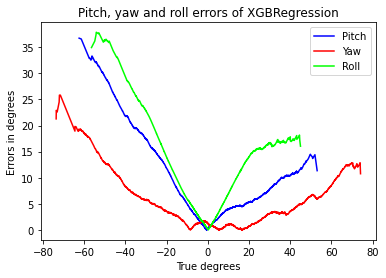

In [ ]:
plt.plot(sort(train_lbl_pitch), errors_pitch, color = (0,  0, 1), label = "Pitch")
plt.plot(sort(train_lbl_yaw), errors_yaw, color = (1,  0, 0), label = "Yaw")
plt.plot(sort(train_lbl_roll), errors_roll, color = (0,  1, 0), label = "Roll")
plt.title("Pitch, yaw and roll errors of XGBRegression")
plt.xlabel("True degrees")
plt.ylabel("Errors in degrees")
plt.legend()
plt.show()

Dai grafici è evidente come l'accuratezza del modello ricalchi quella che è la distribuzione dei dati. I valori di pitch, yaw e roll per cui nel dataset sono presenti molte più immagini, l'errore commesso è quasi nullo, mentre tende ad aumentare per quei valori che presentano meno immagini.

##Autori: Mafalda Ingenito, Ciro Maione, Viviana Pentangelo, Simranjit Singh
###Corso di Fondamenti di Visione Artificiale e Biometria - Prof. M. Nappi
###Toutor: Dott.ssa C. Bisogni, Dott.ssa C. Pero
###Università degli studi di Salerno - Dipartimento di Informatica